In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.neighbors import DistanceMetric
from math import radians
import folium
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import cKDTree
from shapely.geometry import Point
from shapely.ops import nearest_points
import matplotlib.pyplot as plt

# Acessando arquivos 

In [3]:
junho = pd.read_excel('viagens_validas_junho.xlsx', index_col='Unnamed: 0')
junho.rename(columns={'index': 'index_col'}, inplace = True)
junho.loc[junho.dataInicio.dt.month == 6, 'index_col'] = junho['index_col'].astype(str) + '_' + junho.dataInicio.dt.month.astype(str)

julho = pd.read_excel('viagens_validas_julho.xlsx', index_col='Unnamed: 0')
julho.rename(columns={'index': 'index_col'}, inplace = True)
julho.loc[julho.dataInicio.dt.month == 7, 'index_col'] = julho['index_col'].astype(str) + '_' + julho.dataInicio.dt.month.astype(str)

agosto = pd.read_excel('viagens_validas_agosto.xlsx', index_col='Unnamed: 0')
agosto.rename(columns={'index': 'index_col'}, inplace = True)
agosto.loc[agosto.dataInicio.dt.month == 8, 'index_col'] = agosto['index_col'].astype(str) + '_' + agosto.dataInicio.dt.month.astype(str)

viagens_validas = pd.concat([junho, julho, agosto], axis = 0)

viagens_validas

,index_col,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF
0,0_6,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2046.926540,3183.0,-22.826777,-47.061416,-22.829708,-47.060686
1,1_6,1,2,Manha,2021-06-01 06:44:07,2021-06-01 12:33:53,6,390.572020,804.0,-22.826890,-47.061367,-22.827097,-47.061306
2,2_6,1,7,Manha,2021-06-01 06:44:48,2021-06-01 12:34:20,7,1171.826118,787.0,-22.827616,-47.061038,-22.828888,-47.060592
3,3_6,1,7,Tarde,2021-06-01 13:11:22,2021-06-01 16:43:41,6,1165.803784,193.0,-22.827083,-47.061219,-22.828920,-47.060559
4,4_6,1,8,Tarde,2021-06-01 13:04:16,2021-06-01 19:10:52,7,483.412306,359.0,-22.813787,-47.060110,-22.831784,-47.062191
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6010,6010_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974
6011,6011_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974
6012,6012_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974
6013,6013_8,31,93166,Tarde,2021-08-31 16:19:17,2021-08-31 16:23:33,1,821.356800,256.0,-22.831021,-47.063912,-22.824985,-47.065243


In [7]:
viagens_validas.groupby(pd.Grouper(key ='dataInicio', freq='1M')).count()

,index_col,day,device_id,periodo,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF
dataInicio,,,,,,,,,,,,
2021-06-30,4799,4799,4799,4799,4799,4799,4799,4799,4799,4799,4799,4799
2021-07-31,5732,5732,5732,5732,5732,5732,5732,5732,5732,5732,5732,5732
2021-08-31,6015,6015,6015,6015,6015,6015,6015,6015,6015,6015,6015,6015


In [263]:
viagens_validas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16546 entries, 0 to 6014
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   index_col    16546 non-null  object        
 1   day          16546 non-null  int64         
 2   device_id    16546 non-null  int64         
 3   periodo      16546 non-null  object        
 4   dataInicio   16546 non-null  datetime64[ns]
 5   dataFim      16546 non-null  datetime64[ns]
 6   sequence     16546 non-null  int64         
 7   distance(m)  16546 non-null  float64       
 8   duration(s)  16546 non-null  float64       
 9   latitudeI    16546 non-null  float64       
 10  longitudeI   16546 non-null  float64       
 11  latitudeF    16546 non-null  float64       
 12  longitudeF   16546 non-null  float64       
dtypes: datetime64[ns](2), float64(6), int64(3), object(2)
memory usage: 1.8+ MB


# Mapeamento da OD de cada viagem


## Mapas de Densidade

<img src="Imagens/V1_MapaDensidade_CircularI.jpg" alt="Mapa de Densidade Circ1" />

<img src="Imagens/V1_MapaDensidade_FEC.jpg" alt="Mapa de Densidade FEC" />

## Modelagem

In [264]:
ptos = pd.read_excel('Dados brutos/_PontosEletrico_.xlsx').sort_values('Densidade', ascending=False)
ptos

,Ponto,Ordem,Lat,Long,Densidade
0,1,FEC / RS,-22.815664,-47.062650,175527.01560
1,2,RU / BCCL,-22.816567,-47.072617,161245.95310
2,3,ADunicamp (Associação de Docentes da Unicamp),-22.813326,-47.065407,134607.79690
3,4,IC / Pavilhão do IA,-22.815047,-47.064360,131100.25000
4,5,CEPETRO / Funcamp,-22.812777,-47.067752,103630.47660
5,6,NEPP / IC,-22.814714,-47.064024,98755.28906
6,7,FEA / Praça da Paz,-22.821312,-47.067412,95977.38281
7,8,CECI Berçário / FEA,-22.821001,-47.068121,91303.71094
8,9,IB / SIARQ,-22.819147,-47.072227,86938.40625
9,10,IQ / FEA,-22.819335,-47.067119,75935.28125


In [265]:
paradas_eletrico_inicio = pd.read_excel('Dados brutos/_PontosEletrico_.xlsx').sort_values('Densidade', ascending=True)
paradas_eletrico_inicio.rename(columns={'Ponto': 'PontoInicial'}, inplace = True)
paradas_eletrico_final = pd.read_excel('Dados brutos/_PontosEletrico_.xlsx').sort_values('Densidade', ascending=True)
paradas_eletrico_final.rename(columns={'Ponto': 'PontoFinal'}, inplace = True)
paradas_eletrico_final


,PontoFinal,Ordem,Lat,Long,Densidade
34,35,Escola Sérgio P. Porto (PONTO FINAL),-22.827112,-47.061369,0.00000
33,34,Escola Sérgio P. Porto (PONTO INICIAL),-22.827196,-47.061327,0.00000
32,33,SIC / Praça da Paz,-22.822701,-47.069055,27239.38086
31,32,FEAGRI / CCUEC,-22.818269,-47.063075,29556.28906
30,31,FEAGRI / CBMEG,-22.818348,-47.059675,30631.71094
29,30,Hemocentro / FCM,-22.829614,-47.061370,30876.05859
28,29,CCUEC / CENAPAD,-22.818063,-47.063083,32944.09375
27,28,HC / Área da Saúde,-22.828808,-47.066226,34230.80469
26,27,IE / FE,-22.781562,-47.065851,37259.26953
25,26,Sobrapar,-22.827383,-47.067575,37915.86328


In [266]:
gpd1 = gpd.GeoDataFrame(viagens_validas, geometry=gpd.points_from_xy(viagens_validas.longitudeI, viagens_validas.latitudeI))
gpd2 = gpd.GeoDataFrame(paradas_eletrico_inicio, geometry=gpd.points_from_xy(paradas_eletrico_inicio.Long, paradas_eletrico_inicio.Lat))

gpd4 = gpd.GeoDataFrame(viagens_validas, geometry=gpd.points_from_xy(viagens_validas.longitudeF, viagens_validas.latitudeF))
gpd5 = gpd.GeoDataFrame(paradas_eletrico_final, geometry=gpd.points_from_xy(paradas_eletrico_final.Long, paradas_eletrico_final.Lat))


def ckdnearest(gdA, gdB):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

gpd3=ckdnearest(gpd1, gpd2)

gpd4 = gpd.GeoDataFrame(viagens_validas, geometry=gpd.points_from_xy(viagens_validas.longitudeF, viagens_validas.latitudeF))
gpd5 = gpd.GeoDataFrame(paradas_eletrico_final, geometry=gpd.points_from_xy(paradas_eletrico_final.Long, paradas_eletrico_final.Lat))


def ckdnearest(gdA, gdB):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf


gpd6=ckdnearest(gpd4, gpd5)



In [267]:
gpd3

,index_col,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF,geometry,PontoInicial,Ordem,Lat,Long,Densidade,dist
0,0_6,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2046.926540,3183.0,-22.826777,-47.061416,-22.829708,-47.060686,POINT (-47.06069 -22.82971),30,Hemocentro / FCM,-22.829614,-47.061370,30876.05859,0.000691
1,1_6,1,2,Manha,2021-06-01 06:44:07,2021-06-01 12:33:53,6,390.572020,804.0,-22.826890,-47.061367,-22.827097,-47.061306,POINT (-47.06131 -22.82710),35,Escola Sérgio P. Porto (PONTO FINAL),-22.827112,-47.061369,0.00000,0.000065
2,2_6,1,7,Manha,2021-06-01 06:44:48,2021-06-01 12:34:20,7,1171.826118,787.0,-22.827616,-47.061038,-22.828888,-47.060592,POINT (-47.06059 -22.82889),30,Hemocentro / FCM,-22.829614,-47.061370,30876.05859,0.001064
3,3_6,1,7,Tarde,2021-06-01 13:11:22,2021-06-01 16:43:41,6,1165.803784,193.0,-22.827083,-47.061219,-22.828920,-47.060559,POINT (-47.06056 -22.82892),30,Hemocentro / FCM,-22.829614,-47.061370,30876.05859,0.001067
4,4_6,1,8,Tarde,2021-06-01 13:04:16,2021-06-01 19:10:52,7,483.412306,359.0,-22.813787,-47.060110,-22.831784,-47.062191,POINT (-47.06219 -22.83178),30,Hemocentro / FCM,-22.829614,-47.061370,30876.05859,0.002320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16541,6010_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,POINT (-47.06697 -22.82776),18,CAISM / Portaria 2 - HC,-22.827839,-47.066777,48880.90234,0.000213
16542,6011_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,POINT (-47.06697 -22.82776),18,CAISM / Portaria 2 - HC,-22.827839,-47.066777,48880.90234,0.000213
16543,6012_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,POINT (-47.06697 -22.82776),18,CAISM / Portaria 2 - HC,-22.827839,-47.066777,48880.90234,0.000213
16544,6013_8,31,93166,Tarde,2021-08-31 16:19:17,2021-08-31 16:23:33,1,821.356800,256.0,-22.831021,-47.063912,-22.824985,-47.065243,POINT (-47.06524 -22.82499),11,DGA / Praça das Bandeiras,-22.824862,-47.065478,67135.19531,0.000265


In [268]:
gpd6

,index_col,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF,geometry,PontoFinal,Ordem,Lat,Long,Densidade,dist
0,0_6,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2046.926540,3183.0,-22.826777,-47.061416,-22.829708,-47.060686,POINT (-47.06069 -22.82971),30,Hemocentro / FCM,-22.829614,-47.061370,30876.05859,0.000691
1,1_6,1,2,Manha,2021-06-01 06:44:07,2021-06-01 12:33:53,6,390.572020,804.0,-22.826890,-47.061367,-22.827097,-47.061306,POINT (-47.06131 -22.82710),35,Escola Sérgio P. Porto (PONTO FINAL),-22.827112,-47.061369,0.00000,0.000065
2,2_6,1,7,Manha,2021-06-01 06:44:48,2021-06-01 12:34:20,7,1171.826118,787.0,-22.827616,-47.061038,-22.828888,-47.060592,POINT (-47.06059 -22.82889),30,Hemocentro / FCM,-22.829614,-47.061370,30876.05859,0.001064
3,3_6,1,7,Tarde,2021-06-01 13:11:22,2021-06-01 16:43:41,6,1165.803784,193.0,-22.827083,-47.061219,-22.828920,-47.060559,POINT (-47.06056 -22.82892),30,Hemocentro / FCM,-22.829614,-47.061370,30876.05859,0.001067
4,4_6,1,8,Tarde,2021-06-01 13:04:16,2021-06-01 19:10:52,7,483.412306,359.0,-22.813787,-47.060110,-22.831784,-47.062191,POINT (-47.06219 -22.83178),30,Hemocentro / FCM,-22.829614,-47.061370,30876.05859,0.002320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16541,6010_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,POINT (-47.06697 -22.82776),18,CAISM / Portaria 2 - HC,-22.827839,-47.066777,48880.90234,0.000213
16542,6011_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,POINT (-47.06697 -22.82776),18,CAISM / Portaria 2 - HC,-22.827839,-47.066777,48880.90234,0.000213
16543,6012_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,POINT (-47.06697 -22.82776),18,CAISM / Portaria 2 - HC,-22.827839,-47.066777,48880.90234,0.000213
16544,6013_8,31,93166,Tarde,2021-08-31 16:19:17,2021-08-31 16:23:33,1,821.356800,256.0,-22.831021,-47.063912,-22.824985,-47.065243,POINT (-47.06524 -22.82499),11,DGA / Praça das Bandeiras,-22.824862,-47.065478,67135.19531,0.000265


In [269]:
matriz_junho= pd.merge(gpd6, gpd3,how = 'inner' , on = ['index_col','day', 'device_id', 'periodo', 'sequence', 'distance(m)', 'duration(s)', 'dataInicio', 'dataFim','latitudeI', 'longitudeI', 'latitudeF', 'longitudeF'])
matriz_junho = matriz_junho[['index_col','day', 'device_id', 'periodo', 'dataInicio', 'dataFim', 'sequence', 'distance(m)',
       'duration(s)', 'latitudeI', 'longitudeI', 'latitudeF', 'longitudeF',
        'PontoFinal',  'dist_x','PontoInicial', 'dist_y']]

matriz_junho

,index_col,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF,PontoFinal,dist_x,PontoInicial,dist_y
0,0_6,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2046.926540,3183.0,-22.826777,-47.061416,-22.829708,-47.060686,30,0.000691,30,0.000691
1,1_6,1,2,Manha,2021-06-01 06:44:07,2021-06-01 12:33:53,6,390.572020,804.0,-22.826890,-47.061367,-22.827097,-47.061306,35,0.000065,35,0.000065
2,2_6,1,7,Manha,2021-06-01 06:44:48,2021-06-01 12:34:20,7,1171.826118,787.0,-22.827616,-47.061038,-22.828888,-47.060592,30,0.001064,30,0.001064
3,3_6,1,7,Tarde,2021-06-01 13:11:22,2021-06-01 16:43:41,6,1165.803784,193.0,-22.827083,-47.061219,-22.828920,-47.060559,30,0.001067,30,0.001067
4,4_6,1,8,Tarde,2021-06-01 13:04:16,2021-06-01 19:10:52,7,483.412306,359.0,-22.813787,-47.060110,-22.831784,-47.062191,30,0.002320,30,0.002320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16541,6010_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,18,0.000213,18,0.000213
16542,6011_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,18,0.000213,18,0.000213
16543,6012_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,18,0.000213,18,0.000213
16544,6013_8,31,93166,Tarde,2021-08-31 16:19:17,2021-08-31 16:23:33,1,821.356800,256.0,-22.831021,-47.063912,-22.824985,-47.065243,11,0.000265,11,0.000265


In [270]:
matriz_junho_agrupada=matriz_junho.groupby(by=[matriz_junho.dataInicio.dt.month,matriz_junho.day, matriz_junho.periodo,'PontoInicial','PontoFinal']).agg({'sequence': 'count'}).reset_index()

matriz_junho_agrupada

,dataInicio,day,periodo,PontoInicial,PontoFinal,sequence
0,6,1,Manha,1,1,1
1,6,1,Manha,2,2,1
2,6,1,Manha,6,6,3
3,6,1,Manha,7,7,2
4,6,1,Manha,8,8,4
...,...,...,...,...,...,...
3567,8,31,Tarde,28,28,3
3568,8,31,Tarde,29,29,3
3569,8,31,Tarde,30,30,4
3570,8,31,Tarde,32,32,1


In [271]:
pivotttt = matriz_junho_agrupada[   (matriz_junho_agrupada['dataInicio'] == 6)  &
                                    (matriz_junho_agrupada['day'] == 1)         &
                                    (matriz_junho_agrupada['periodo'] == 'Tarde')].pivot(index= 'PontoInicial', columns='PontoFinal', values='sequence').fillna(0)
pivotttt

PontoFinal,1,2,3,4,6,7,8,10,11,12,...,21,22,24,26,28,29,30,32,33,34
PontoInicial,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [272]:
matriz_junho_agrupada=matriz_junho.groupby(by=['day','PontoInicial','PontoFinal']).count()
matriz_junho_agrupada

index_col  device_id  periodo  dataInicio  \
day PontoInicial PontoFinal                                              
1   1            1                  10         10       10          10   
    2            2                  17         17       17          17   
    3            3                   7          7        7           7   
    4            4                   2          2        2           2   
    6            6                  18         18       18          18   
...                                ...        ...      ...         ...   
31  30           30                 16         16       16          16   
    31           31                  1          1        1           1   
    32           32                  2          2        2           2   
    33           33                  6          6        6           6   
    34           34                  1          1        1           1   

                             dataFim  sequence  distance(m)  duration(s)  \
day PontoInicial PontoFinal                                                
1   1            1                10        10           10           10   
    2            2                17        17           17           17   
    3            3                 7         7            7            7   
    4            4                 2         2            2            2   
    6            6                18        18           18           18   
...                              ...       ...          ...          ...   
31  30           30               16        16           16           16   
    31           31                1         1            1            1   
    32           32                2         2            2            2   
    33           33                6         6            6            6   
    34           34                1         1            1            1   

                             latitudeI  longitudeI  latitudeF  longitudeF  \
day PontoInicial PontoFinal                                                 
1   1            1                  10          10         10          10   
    2            2                  17          17         17          17   
    3            3                   7           7          7           7   
    4            4                   2           2          2           2   
    6            6                  18          18         18          18   
...                                ...         ...        ...         ...   
31  30           30                 16          16         16          16   
    31           31                  1           1          1           1   
    32           32                  2           2          2           2   
    33           33                  6           6          6           6   
    34           34                  1           1          1           1   

                             dist_x  dist_y  
day PontoInicial PontoFinal                  
1   1            1               10      10  
    2            2               17      17  
    3            3                7       7  
    4            4                2       2  
    6            6               18      18  
...                             ...     ...  
31  30           30              16      16  
    31           31               1       1  
    32           32               2       2  
    33           33               6       6  
    34           34               1       1  

[1015 rows x 14 columns]

In [273]:
matriz_junho_1=matriz_junho.loc[matriz_junho['day']==1]
matriz_junho_1
# matriz_junho_1.to_excel('matriz_junho_agrupada_1.xlsx', index = False)

,index_col,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF,PontoFinal,dist_x,PontoInicial,dist_y
0,0_6,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2046.926540,3183.0,-22.826777,-47.061416,-22.829708,-47.060686,30,0.000691,30,0.000691
1,1_6,1,2,Manha,2021-06-01 06:44:07,2021-06-01 12:33:53,6,390.572020,804.0,-22.826890,-47.061367,-22.827097,-47.061306,35,0.000065,35,0.000065
2,2_6,1,7,Manha,2021-06-01 06:44:48,2021-06-01 12:34:20,7,1171.826118,787.0,-22.827616,-47.061038,-22.828888,-47.060592,30,0.001064,30,0.001064
3,3_6,1,7,Tarde,2021-06-01 13:11:22,2021-06-01 16:43:41,6,1165.803784,193.0,-22.827083,-47.061219,-22.828920,-47.060559,30,0.001067,30,0.001067
4,4_6,1,8,Tarde,2021-06-01 13:04:16,2021-06-01 19:10:52,7,483.412306,359.0,-22.813787,-47.060110,-22.831784,-47.062191,30,0.002320,30,0.002320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4982,183_7,1,4222,Tarde,2021-07-01 18:35:41,2021-07-01 18:40:24,1,449.993315,283.0,-22.828609,-47.066269,-22.825300,-47.065551,11,0.000444,11,0.000444
4983,184_7,1,4305,Tarde,2021-07-01 18:43:30,2021-07-01 18:47:04,1,366.536299,214.0,-22.820078,-47.065609,-22.818040,-47.063608,29,0.000525,29,0.000525
4984,185_7,1,4374,Tarde,2021-07-01 19:04:38,2021-07-01 19:20:01,1,408.467081,923.0,-22.814343,-47.067751,-22.814191,-47.064432,6,0.000663,6,0.000663
4985,186_7,1,4417,Tarde,2021-07-01 19:09:43,2021-07-01 19:16:30,1,485.392237,407.0,-22.827591,-47.067245,-22.824011,-47.067959,17,0.000320,17,0.000320


# Resolvendo o p-Medianas

In [274]:
from pyclustering.cluster.kmedians import kmedians
from pyclustering.cluster import cluster_visualizer

In [275]:
matriz_junho.head(15)

,index_col,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF,PontoFinal,dist_x,PontoInicial,dist_y
0,0_6,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2046.926540,3183.0,-22.826777,-47.061416,-22.829708,-47.060686,30,0.000691,30,0.000691
1,1_6,1,2,Manha,2021-06-01 06:44:07,2021-06-01 12:33:53,6,390.572020,804.0,-22.826890,-47.061367,-22.827097,-47.061306,35,0.000065,35,0.000065
2,2_6,1,7,Manha,2021-06-01 06:44:48,2021-06-01 12:34:20,7,1171.826118,787.0,-22.827616,-47.061038,-22.828888,-47.060592,30,0.001064,30,0.001064
3,3_6,1,7,Tarde,2021-06-01 13:11:22,2021-06-01 16:43:41,6,1165.803784,193.0,-22.827083,-47.061219,-22.828920,-47.060559,30,0.001067,30,0.001067
4,4_6,1,8,Tarde,2021-06-01 13:04:16,2021-06-01 19:10:52,7,483.412306,359.0,-22.813787,-47.060110,-22.831784,-47.062191,30,0.002320,30,0.002320
5,5_6,1,10,Manha,2021-06-01 07:12:06,2021-06-01 12:34:25,5,584.740213,73.0,-22.828233,-47.060820,-22.829112,-47.060477,30,0.001024,30,0.001024
6,6_6,1,10,Tarde,2021-06-01 13:12:20,2021-06-01 17:05:16,6,774.077323,2797.0,-22.828498,-47.060741,-22.829695,-47.061042,30,0.000338,30,0.000338
7,7_6,1,15,Tarde,2021-06-01 14:57:28,2021-06-01 16:43:50,2,365.611485,91.0,-22.826819,-47.061479,-22.829299,-47.060340,30,0.001077,30,0.001077
8,8_6,1,21,Manha,2021-06-01 07:58:35,2021-06-01 12:32:24,3,391.997417,607.0,-22.826375,-47.061788,-22.827425,-47.061065,34,0.000348,34,0.000348
9,9_6,1,21,Tarde,2021-06-01 14:32:37,2021-06-01 16:43:27,4,407.155363,125.0,-22.827339,-47.061163,-22.827882,-47.060964,34,0.000776,34,0.000776


In [276]:
paradas_eletrico_final.head(10)

,PontoFinal,Ordem,Lat,Long,Densidade,geometry
34,35,Escola Sérgio P. Porto (PONTO FINAL),-22.827112,-47.061369,0.00000,POINT (-47.06137 -22.82711)
33,34,Escola Sérgio P. Porto (PONTO INICIAL),-22.827196,-47.061327,0.00000,POINT (-47.06133 -22.82720)
32,33,SIC / Praça da Paz,-22.822701,-47.069055,27239.38086,POINT (-47.06905 -22.82270)
31,32,FEAGRI / CCUEC,-22.818269,-47.063075,29556.28906,POINT (-47.06307 -22.81827)
30,31,FEAGRI / CBMEG,-22.818348,-47.059675,30631.71094,POINT (-47.05968 -22.81835)
29,30,Hemocentro / FCM,-22.829614,-47.061370,30876.05859,POINT (-47.06137 -22.82961)
28,29,CCUEC / CENAPAD,-22.818063,-47.063083,32944.09375,POINT (-47.06308 -22.81806)
27,28,HC / Área da Saúde,-22.828808,-47.066226,34230.80469,POINT (-47.06623 -22.82881)
26,27,IE / FE,-22.781562,-47.065851,37259.26953,POINT (-47.06585 -22.78156)
25,26,Sobrapar,-22.827383,-47.067575,37915.86328,POINT (-47.06758 -22.82738)


In [277]:
# kmedians.__init__	(	 	self, 	data, 	initial_centers, 	tolerance = 0.001, 	ccore = True, 	kwargs )		

# [in]	data	(list): Input data that is presented as list of points (objects), each point should be represented by list or tuple.
# [in]	initial_centers	(list): Initial coordinates of medians of clusters that are represented by list: [center1, center2, ...].
# [in]	tolerance	(double): Stop condition: if maximum value of change of centers of clusters is less than tolerance than algorithm will stop processing
# [in]	ccore	(bool): Defines should be CCORE library (C++ pyclustering library) used instead of Python code or not.
# [in]	**kwargs	Arbitrary keyword arguments (available arguments: 'metric', 'itermax').

# print(kmedians_instance)

In [278]:
def apply_kmedians(latlong_paradas, latlong_viagens):
    kmedians_instance = kmedians(latlong_viagens, latlong_paradas)
    kmedians_instance.process()
    viagens_por_parada = kmedians_instance.get_clusters()
    pontos_parada = kmedians_instance.get_medians()

    return pontos_parada, viagens_por_parada


In [279]:
pontos_parada_antes = paradas_eletrico_final.loc[paradas_eletrico_final['PontoFinal'].isin([i for i in range(8)]), ['Lat','Long']].values.tolist()
paradas_eletrico_final.loc[paradas_eletrico_final['PontoFinal'].isin([i for i in range(8)])]

,PontoFinal,Ordem,Lat,Long,Densidade,geometry
6,7,FEA / Praça da Paz,-22.821312,-47.067412,95977.38281,POINT (-47.06741 -22.82131)
5,6,NEPP / IC,-22.814714,-47.064024,98755.28906,POINT (-47.06402 -22.81471)
4,5,CEPETRO / Funcamp,-22.812777,-47.067752,103630.47660,POINT (-47.06775 -22.81278)
3,4,IC / Pavilhão do IA,-22.815047,-47.064360,131100.25000,POINT (-47.06436 -22.81505)
2,3,ADunicamp (Associação de Docentes da Unicamp),-22.813326,-47.065407,134607.79690,POINT (-47.06541 -22.81333)
1,2,RU / BCCL,-22.816567,-47.072617,161245.95310,POINT (-47.07262 -22.81657)
0,1,FEC / RS,-22.815664,-47.062650,175527.01560,POINT (-47.06265 -22.81566)


In [280]:
pontos_viagens = matriz_junho.loc[matriz_junho['day'] == 1, ['latitudeI','longitudeI']].values.tolist()

In [281]:
# pontos_parada, viagens_por_parada = apply_kmedians(pontos_parada_antes, pontos_viagens)

In [282]:
print(len(viagens_por_parada))
for num in range(len(viagens_por_parada)):
    
    print(num, 'ponto de parada ',pontos_parada[num], 'quantidade de viagens com origem ai',len(viagens_por_parada[num]))#, '\n',clusters[num])

19
0 ponto de parada  [-22.813916, -47.070441] quantidade de viagens com origem ai 6
1 ponto de parada  [-22.822135, -47.061394] quantidade de viagens com origem ai 4
2 ponto de parada  [-22.828303, -47.0665065] quantidade de viagens com origem ai 8
3 ponto de parada  [-22.823728, -47.068254] quantidade de viagens com origem ai 29
4 ponto de parada  [-22.8175655, -47.066199499999996] quantidade de viagens com origem ai 7
5 ponto de parada  [-22.818925999999998, -47.064562] quantidade de viagens com origem ai 9
6 ponto de parada  [-22.8297045, -47.062418] quantidade de viagens com origem ai 16
7 ponto de parada  [-22.8155795, -47.066455500000004] quantidade de viagens com origem ai 37
8 ponto de parada  [-22.8254175, -47.0665215] quantidade de viagens com origem ai 1
9 ponto de parada  [-22.824928, -47.065403] quantidade de viagens com origem ai 35
10 ponto de parada  [-22.819497, -47.067244] quantidade de viagens com origem ai 62
11 ponto de parada  [-22.8188815, -47.0722995] quantidad

In [283]:
pontos_onibus = paradas_eletrico_final.loc[paradas_eletrico_final['PontoFinal'].isin([i for i in range(8)]), ['Lat','Long']].values.tolist()
paradas_eletrico_final.loc[paradas_eletrico_final['PontoFinal'].isin([i for i in range(8)])]

,PontoFinal,Ordem,Lat,Long,Densidade,geometry
6,7,FEA / Praça da Paz,-22.821312,-47.067412,95977.38281,POINT (-47.06741 -22.82131)
5,6,NEPP / IC,-22.814714,-47.064024,98755.28906,POINT (-47.06402 -22.81471)
4,5,CEPETRO / Funcamp,-22.812777,-47.067752,103630.47660,POINT (-47.06775 -22.81278)
3,4,IC / Pavilhão do IA,-22.815047,-47.064360,131100.25000,POINT (-47.06436 -22.81505)
2,3,ADunicamp (Associação de Docentes da Unicamp),-22.813326,-47.065407,134607.79690,POINT (-47.06541 -22.81333)
1,2,RU / BCCL,-22.816567,-47.072617,161245.95310,POINT (-47.07262 -22.81657)
0,1,FEC / RS,-22.815664,-47.062650,175527.01560,POINT (-47.06265 -22.81566)


In [284]:
pontos_viagens = matriz_junho.loc[matriz_junho['day'] == 1, ['latitudeI','longitudeI']].values.tolist()

In [285]:
# kmedians.__init__	(	 	self, 	data, 	initial_centers, 	tolerance = 0.001, 	ccore = True, 	kwargs )		

# [in]	data	(list): Input data that is presented as list of points (objects), each point should be represented by list or tuple.
# [in]	initial_centers	(list): Initial coordinates of medians of clusters that are represented by list: [center1, center2, ...].
# [in]	tolerance	(double): Stop condition: if maximum value of change of centers of clusters is less than tolerance than algorithm will stop processing
# [in]	ccore	(bool): Defines should be CCORE library (C++ pyclustering library) used instead of Python code or not.
# [in]	**kwargs	Arbitrary keyword arguments (available arguments: 'metric', 'itermax').

kmedians_instance = kmedians(pontos_viagens, pontos_onibus)
# print(kmedians_instance)

In [286]:

# Run cluster analysis and obtain results.
kmedians_instance.process()
clusters = kmedians_instance.get_clusters()
medians = kmedians_instance.get_medians()

In [287]:
print(len(clusters))
for num in range(len(clusters)):
    
    print(num, len(clusters[num]), '\n',clusters[num])

7
0 237 
 [0, 1, 2, 3, 5, 6, 7, 8, 9, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 81, 86, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 110, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 130, 131, 132, 133, 135, 136, 137, 138, 139, 140, 145, 146, 149, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 166, 167, 169, 170, 171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 270, 273, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 294, 295, 296, 297, 304, 305, 309, 310, 311, 312, 313, 314, 319, 320, 322, 323, 327, 328, 329, 330, 331, 332, 3

In [288]:
pontos_viagens = matriz_junho.loc[matriz_junho['day'] == 1, ['latitudeI','longitudeI']].values.tolist()
# print(pontos_viagens)


for num in range(7,22):
    
    print(num, 'N PONTOS DE ONIBUS')
    pontos_parada_antes = paradas_eletrico_final.loc[paradas_eletrico_final['PontoFinal'].index.isin([i for i in range(num)]), ['Lat','Long']].values.tolist()
    print(pontos_parada_antes)
    pontos_parada, viagens_por_parada = apply_kmedians(pontos_parada_antes, pontos_viagens)

    for lensss in range(len(viagens_por_parada)):
    
        print('ponto de onibus --> ',lensss, 'quando pontos tem:',len(viagens_por_parada[lensss]))#, '\n',viagens_por_parada[lensss])


7 N PONTOS DE ONIBUS
[[-22.82131206, -47.06741184], [-22.81471355, -47.06402421], [-22.81277738, -47.06775248], [-22.81504659, -47.06436016], [-22.81332608, -47.06540721], [-22.81656666, -47.07261734], [-22.81566371, -47.06265025]]
ponto de onibus -->  0 quando pontos tem: 237
ponto de onibus -->  1 quando pontos tem: 7
ponto de onibus -->  2 quando pontos tem: 7
ponto de onibus -->  3 quando pontos tem: 9
ponto de onibus -->  4 quando pontos tem: 3
ponto de onibus -->  5 quando pontos tem: 24
ponto de onibus -->  6 quando pontos tem: 76
8 N PONTOS DE ONIBUS
[[-22.82100089, -47.06812128], [-22.82131206, -47.06741184], [-22.81471355, -47.06402421], [-22.81277738, -47.06775248], [-22.81504659, -47.06436016], [-22.81332608, -47.06540721], [-22.81656666, -47.07261734], [-22.81566371, -47.06265025]]
ponto de onibus -->  0 quando pontos tem: 24
ponto de onibus -->  1 quando pontos tem: 213
ponto de onibus -->  2 quando pontos tem: 7
ponto de onibus -->  3 quando pontos tem: 7
ponto de onibus

In [289]:
paradas_eletrico_final.loc[paradas_eletrico_final['PontoFinal'].index.isin([i for i in range(14)])]

,PontoFinal,Ordem,Lat,Long,Densidade,geometry
13,14,CECOM,-22.829510,-47.063929,55047.34375,POINT (-47.06393 -22.82951)
12,13,IE / FE,-22.815618,-47.065851,61756.07031,POINT (-47.06585 -22.81562)
11,12,HC (Portaria F1),-22.825726,-47.066183,66145.30469,POINT (-47.06618 -22.82573)
10,11,DGA / Praça das Bandeiras,-22.824862,-47.065478,67135.19531,POINT (-47.06548 -22.82486)
9,10,IQ / FEA,-22.819335,-47.067119,75935.28125,POINT (-47.06712 -22.81933)
8,9,IB / SIARQ,-22.819147,-47.072227,86938.40625,POINT (-47.07223 -22.81915)
7,8,CECI Berçário / FEA,-22.821001,-47.068121,91303.71094,POINT (-47.06812 -22.82100)
6,7,FEA / Praça da Paz,-22.821312,-47.067412,95977.38281,POINT (-47.06741 -22.82131)
5,6,NEPP / IC,-22.814714,-47.064024,98755.28906,POINT (-47.06402 -22.81471)
4,5,CEPETRO / Funcamp,-22.812777,-47.067752,103630.47660,POINT (-47.06775 -22.81278)


In [290]:
# matriz_junho.drop( labels = ['PontoFinal',	'dist_x',	'PontoInicial',	'dist_y'] , axis = 1, inplace = True)
# matriz_junho

In [291]:
matriz_junho.loc[:, 'PontoFinal'] = None
matriz_junho.loc[:, 'PontoInicial'] = None
matriz_junho

,index_col,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF,PontoFinal,dist_x,PontoInicial,dist_y
0,0_6,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2046.926540,3183.0,-22.826777,-47.061416,-22.829708,-47.060686,None,0.000691,None,0.000691
1,1_6,1,2,Manha,2021-06-01 06:44:07,2021-06-01 12:33:53,6,390.572020,804.0,-22.826890,-47.061367,-22.827097,-47.061306,None,0.000065,None,0.000065
2,2_6,1,7,Manha,2021-06-01 06:44:48,2021-06-01 12:34:20,7,1171.826118,787.0,-22.827616,-47.061038,-22.828888,-47.060592,None,0.001064,None,0.001064
3,3_6,1,7,Tarde,2021-06-01 13:11:22,2021-06-01 16:43:41,6,1165.803784,193.0,-22.827083,-47.061219,-22.828920,-47.060559,None,0.001067,None,0.001067
4,4_6,1,8,Tarde,2021-06-01 13:04:16,2021-06-01 19:10:52,7,483.412306,359.0,-22.813787,-47.060110,-22.831784,-47.062191,None,0.002320,None,0.002320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16541,6010_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,None,0.000213,None,0.000213
16542,6011_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,None,0.000213,None,0.000213
16543,6012_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,None,0.000213,None,0.000213
16544,6013_8,31,93166,Tarde,2021-08-31 16:19:17,2021-08-31 16:23:33,1,821.356800,256.0,-22.831021,-47.063912,-22.824985,-47.065243,None,0.000265,None,0.000265


In [292]:
matriz_junho.iloc[:,13]



0        None
1        None
2        None
3        None
4        None
         ... 
16541    None
16542    None
16543    None
16544    None
16545    None
Name: PontoFinal, Length: 16546, dtype: object

In [293]:
paradas_eletrico_inicio


,PontoInicial,Ordem,Lat,Long,Densidade,geometry
34,35,Escola Sérgio P. Porto (PONTO FINAL),-22.827112,-47.061369,0.00000,POINT (-47.06137 -22.82711)
33,34,Escola Sérgio P. Porto (PONTO INICIAL),-22.827196,-47.061327,0.00000,POINT (-47.06133 -22.82720)
32,33,SIC / Praça da Paz,-22.822701,-47.069055,27239.38086,POINT (-47.06905 -22.82270)
31,32,FEAGRI / CCUEC,-22.818269,-47.063075,29556.28906,POINT (-47.06307 -22.81827)
30,31,FEAGRI / CBMEG,-22.818348,-47.059675,30631.71094,POINT (-47.05968 -22.81835)
29,30,Hemocentro / FCM,-22.829614,-47.061370,30876.05859,POINT (-47.06137 -22.82961)
28,29,CCUEC / CENAPAD,-22.818063,-47.063083,32944.09375,POINT (-47.06308 -22.81806)
27,28,HC / Área da Saúde,-22.828808,-47.066226,34230.80469,POINT (-47.06623 -22.82881)
26,27,IE / FE,-22.781562,-47.065851,37259.26953,POINT (-47.06585 -22.78156)
25,26,Sobrapar,-22.827383,-47.067575,37915.86328,POINT (-47.06758 -22.82738)


In [294]:
paradas_eletrico_inicio.loc[paradas_eletrico_inicio['PontoInicial'].index.isin([i for i in range(34)]), ['Ordem', 'Lat','Long']]


,Ordem,Lat,Long
33,Escola Sérgio P. Porto (PONTO INICIAL),-22.827196,-47.061327
32,SIC / Praça da Paz,-22.822701,-47.069055
31,FEAGRI / CCUEC,-22.818269,-47.063075
30,FEAGRI / CBMEG,-22.818348,-47.059675
29,Hemocentro / FCM,-22.829614,-47.061370
28,CCUEC / CENAPAD,-22.818063,-47.063083
27,HC / Área da Saúde,-22.828808,-47.066226
26,IE / FE,-22.781562,-47.065851
25,Sobrapar,-22.827383,-47.067575
24,IB / Zoologia,-22.821469,-47.070225


In [295]:
len(pontos_parada_antes)

21

In [297]:
matriz_junho.loc[:, 'PontoFinal'] = None
matriz_junho.loc[:, 'PontoInicial'] = None
Erros=[]
#pontos_viagens = matriz_junho.loc[:, ['latitudeI','longitudeI']].values.tolist()
pontos_viagens_inicio = matriz_junho.loc[:, ['latitudeI','longitudeI']].values.tolist()
pontos_viagens_final = matriz_junho.loc[:, ['latitudeF','longitudeF']].values.tolist()
# print(pontos_viagens)

# para n  numero de pontos de onibus
#       pega o numero de pontos no paradas_eletrico_inicio
#       roda o kmedians pra essa quantidade de pontos
#       
#       para cada ponto de onibus, aplicar no dataframe

for n_pontos in range(1,35):
    
    pontos_parada_antes = paradas_eletrico_inicio.loc[paradas_eletrico_inicio['PontoInicial'].index.isin([i for i in range(n_pontos)]), ['Lat','Long']].values.tolist()
    print('numero de pontos de parada -->', len(pontos_parada_antes))


    # pontos_parada_depois = paradas_eletrico_final.loc[paradas_eletrico_final['PontoFinal'].index.isin([i for i in range(n_pontos)]), ['Lat','Long']].values.tolist()

    pontos_parada, viagens_por_parada_inicio = apply_kmedians(pontos_parada_antes, pontos_viagens_inicio)
    pontos_parada, viagens_por_parada_final = apply_kmedians(pontos_parada_antes, pontos_viagens_final)

    print('viagens_por_parada_inicio --> ',len(viagens_por_parada_inicio))
    print('viagens_por_parada_final --> ',len(viagens_por_parada_final))
    for aux in range(0,len(viagens_por_parada_inicio)):
        # print(aux)
        
        # atribuicao dos ponto inicial
        # print(paradas_eletrico_inicio.at[ aux,'PontoInicial'])
        matriz_junho.iloc[matriz_junho.index.isin(viagens_por_parada_inicio[aux]), 15] = paradas_eletrico_inicio.at[ aux,'PontoInicial']

        # display(matriz_junho.iloc[matriz_junho.index.isin(viagens_por_parada_inicio[aux]), 14])

        # atribuicao dos ponto final
        matriz_junho.iloc[matriz_junho.index.isin(viagens_por_parada_final[aux]), 13] = paradas_eletrico_inicio.at[ aux,'PontoInicial']
        #matriz_junho.iloc[matriz_junho.index.isin(viagens_por_parada_final[aux]), 13] = paradas_eletrico_inicio.at[ aux,'PontoFinal']
        
    agrupamento_junho = matriz_junho.groupby(['PontoInicial','PontoFinal']).agg({'sequence':'count'}).reset_index()
    OD_junho = agrupamento_junho.pivot(index= 'PontoInicial', columns='PontoFinal', values='sequence').fillna(0)
    # display(OD_junho)
    OD=np.array(OD_junho) 
    Diagonal = (OD.trace())
    Total = np.sum(OD)
    Erro = ((Diagonal)/Total)*100
    print('Soma da Diagonal ',Diagonal, 'Porcentagem %', (round(Erro,2)))
    Erros.append(Erro) 



numero de pontos de parada --> 1
pontos_viagens_inicioa --> 16546
pontos_viagens_final --> 16546
viagens_por_parada_inicio -->  1
viagens_por_parada_final -->  1
Soma da Diagonal  16546 Porcentagem % 100.0
numero de pontos de parada --> 2
pontos_viagens_inicioa --> 16546
pontos_viagens_final --> 16546
viagens_por_parada_inicio -->  2
viagens_por_parada_final -->  2
Soma da Diagonal  12337 Porcentagem % 74.56
numero de pontos de parada --> 3
pontos_viagens_inicioa --> 16546
pontos_viagens_final --> 16546
viagens_por_parada_inicio -->  3
viagens_por_parada_final -->  3
Soma da Diagonal  11551 Porcentagem % 69.81
numero de pontos de parada --> 4
pontos_viagens_inicioa --> 16546
pontos_viagens_final --> 16546
viagens_por_parada_inicio -->  4
viagens_por_parada_final -->  4
Soma da Diagonal  10825 Porcentagem % 65.42
numero de pontos de parada --> 5
pontos_viagens_inicioa --> 16546
pontos_viagens_final --> 16546
viagens_por_parada_inicio -->  5
viagens_por_parada_final -->  5
Soma da Diagon

IndexError: list index out of range

In [299]:
matriz_junho.loc[:, 'PontoFinal'] = None
matriz_junho.loc[:, 'PontoInicial'] = None
Erros=[]
#pontos_viagens = matriz_junho.loc[:, ['latitudeI','longitudeI']].values.tolist()
pontos_viagens_inicio = matriz_junho.loc[:, ['latitudeI','longitudeI']].values.tolist()
pontos_viagens_final = matriz_junho.loc[:, ['latitudeF','longitudeF']].values.tolist()
# print(pontos_viagens)

# para n  numero de pontos de onibus
#       pega o numero de pontos no paradas_eletrico_inicio
#       roda o kmedians pra essa quantidade de pontos
#       
#       para cada ponto de onibus, aplicar no dataframe

for n_pontos in range(1,35):
    
    pontos_parada_antes = paradas_eletrico_inicio.loc[paradas_eletrico_inicio['PontoInicial'].index.isin([i for i in range(n_pontos)]), ['Lat','Long']].values.tolist()

    pontos_parada, viagens_por_parada_inicio = apply_kmedians(pontos_parada_antes, pontos_viagens_inicio)
    pontos_parada, viagens_por_parada_final = apply_kmedians(pontos_parada_antes, pontos_viagens_final)


    for aux in range(len(viagens_por_parada_inicio)):
        # print(aux)
        
        # atribuicao dos ponto inicial
        # print(paradas_eletrico_inicio.at[ aux,'PontoInicial'])
        matriz_junho.iloc[matriz_junho.index.isin(viagens_por_parada_inicio[aux]), 15] = paradas_eletrico_inicio.at[ aux,'PontoInicial']

        # display(matriz_junho.iloc[matriz_junho.index.isin(viagens_por_parada_inicio[aux]), 14])

        # atribuicao dos ponto final
        matriz_junho.iloc[matriz_junho.index.isin(viagens_por_parada_final[aux]), 13] = paradas_eletrico_inicio.at[ aux,'PontoInicial']
        #matriz_junho.iloc[matriz_junho.index.isin(viagens_por_parada_final[aux]), 13] = paradas_eletrico_inicio.at[ aux,'PontoFinal']
        
    agrupamento_junho = matriz_junho.groupby(['PontoInicial','PontoFinal']).agg({'sequence':'count'}).reset_index()
    OD_junho = agrupamento_junho.pivot(index= 'PontoInicial', columns='PontoFinal', values='sequence').fillna(0)
    display(OD_junho)
    OD=np.array(OD_junho) 
    Diagonal = (OD.trace())
    Total = np.sum(OD)
    Erro = ((OD.trace())/21245)*100
    print('Soma da Diagonal ',Diagonal, 'Porcentagem %', (round(Erro,2)))
    Erros.append(Erro) 



PontoFinal,1
PontoInicial,
1,16546


Soma da Diagonal  16546 Porcentagem % 77.88


PontoFinal,1,2
PontoInicial,,
1,2935,2176
2,2033,9402


Soma da Diagonal  12337 Porcentagem % 58.07


PontoFinal,1,2,3
PontoInicial,,,
1,683,141,443
2,302,2700,1862
3,366,1881,8168


Soma da Diagonal  11551 Porcentagem % 54.37


PontoFinal,1,2,3,4
PontoInicial,,,,
1,1065,89,392,581
2,128,408,78,153
3,317,238,2417,1579
4,371,181,1614,6935


Soma da Diagonal  10825 Porcentagem % 50.95


PontoFinal,1,2,3,4,5
PontoInicial,,,,,
1,280,52,45,93,76
2,27,1065,71,383,581
3,23,91,104,16,94
4,235,302,53,2292,1562
5,74,371,132,1589,6935


Soma da Diagonal  10676 Porcentagem % 50.25


PontoFinal,1,2,3,4,5,6
PontoInicial,,,,,,
1,206,7,26,41,13,202
2,22,280,39,36,93,76
3,39,22,916,29,372,451
4,67,21,15,60,14,60
5,58,235,263,37,2292,1559
6,312,74,230,80,1589,6710


Soma da Diagonal  10464 Porcentagem % 49.25


PontoFinal,1,2,3,4,5,6,7
PontoInicial,,,,,,,
1,8697,70,120,77,44,549,449
2,33,206,7,21,41,10,177
3,85,22,280,18,36,59,46
4,169,29,12,229,19,32,82
5,15,67,21,15,60,10,49
6,482,26,182,49,17,877,119
7,348,284,17,78,66,55,2090


Soma da Diagonal  12439 Porcentagem % 58.55


PontoFinal,1,2,3,4,5,6,7,8
PontoInicial,,,,,,,,
1,526,374,9,27,7,8,186,60
2,680,7132,61,93,71,36,411,389
3,2,31,206,7,21,41,10,177
4,17,68,22,280,18,36,59,46
5,36,133,29,12,229,19,32,82
6,2,13,67,21,15,60,10,49
7,80,400,26,182,48,17,816,119
8,21,327,284,17,78,66,55,2090


Soma da Diagonal  11339 Porcentagem % 53.37


PontoFinal,1,2,3,4,5,6,7,8,9
PontoInicial,,,,,,,,,
1,258.0,21.0,46.0,0.0,22.0,15.0,0.0,85.0,3.0
2,48.0,498.0,363.0,9.0,22.0,6.0,8.0,72.0,60.0
3,117.0,660.0,7132.0,61.0,93.0,71.0,36.0,314.0,389.0
4,0.0,2.0,31.0,206.0,7.0,21.0,41.0,10.0,177.0
5,0.0,17.0,68.0,22.0,280.0,18.0,36.0,59.0,46.0
6,0.0,36.0,133.0,29.0,12.0,229.0,19.0,32.0,82.0
7,1.0,2.0,13.0,67.0,21.0,15.0,60.0,9.0,49.0
8,6.0,65.0,365.0,26.0,165.0,34.0,17.0,555.0,116.0
9,2.0,21.0,327.0,284.0,17.0,78.0,66.0,53.0,2090.0


Soma da Diagonal  11308.0 Porcentagem % 53.23


PontoFinal,1,2,3,4,5,6,7,8,9,10
PontoInicial,,,,,,,,,,
1,553.0,1.0,198.0,213.0,18.0,16.0,25.0,8.0,39.0,217.0
2,17.0,258.0,13.0,43.0,0.0,22.0,9.0,0.0,85.0,3.0
3,61.0,48.0,173.0,210.0,9.0,20.0,1.0,8.0,69.0,41.0
4,277.0,117.0,598.0,6653.0,50.0,87.0,28.0,31.0,301.0,225.0
5,9.0,0.0,0.0,27.0,206.0,7.0,21.0,41.0,10.0,174.0
6,21.0,0.0,14.0,59.0,22.0,280.0,10.0,36.0,59.0,45.0
7,60.0,0.0,7.0,52.0,28.0,9.0,135.0,18.0,18.0,55.0
8,11.0,1.0,2.0,11.0,67.0,21.0,7.0,60.0,9.0,48.0
9,73.0,6.0,52.0,329.0,26.0,165.0,14.0,17.0,555.0,112.0


Soma da Diagonal  10836.0 Porcentagem % 51.0


PontoFinal,1,2,3,4,5,6,7,8,9,10,11
PontoInicial,,,,,,,,,,,
1,6138.0,80.0,110.0,538.0,232.0,38.0,79.0,24.0,24.0,273.0,149.0
2,95.0,553.0,1.0,198.0,119.0,18.0,16.0,25.0,8.0,39.0,216.0
3,35.0,17.0,258.0,13.0,8.0,0.0,22.0,9.0,0.0,85.0,3.0
4,123.0,61.0,48.0,173.0,88.0,9.0,20.0,1.0,8.0,69.0,40.0
5,110.0,197.0,7.0,60.0,190.0,12.0,8.0,4.0,7.0,28.0,75.0
6,26.0,9.0,0.0,0.0,1.0,206.0,7.0,21.0,41.0,10.0,174.0
7,42.0,21.0,0.0,14.0,19.0,22.0,280.0,10.0,36.0,59.0,43.0
8,40.0,60.0,0.0,7.0,12.0,28.0,9.0,135.0,18.0,18.0,55.0
9,10.0,11.0,1.0,2.0,1.0,67.0,21.0,7.0,60.0,9.0,48.0


Soma da Diagonal  10477.0 Porcentagem % 49.32


PontoFinal,1,2,3,4,5,6,7,8,9,10,11,12
PontoInicial,,,,,,,,,,,,
1,3822.0,453.0,58.0,94.0,446.0,174.0,25.0,60.0,15.0,19.0,213.0,90.0
2,973.0,904.0,22.0,16.0,95.0,51.0,13.0,19.0,9.0,5.0,60.0,60.0
3,65.0,30.0,553.0,1.0,198.0,119.0,18.0,16.0,25.0,8.0,39.0,216.0
4,28.0,7.0,17.0,258.0,13.0,8.0,0.0,22.0,9.0,0.0,85.0,3.0
5,94.0,30.0,61.0,48.0,173.0,87.0,9.0,20.0,1.0,8.0,69.0,40.0
6,48.0,60.0,197.0,7.0,57.0,185.0,12.0,8.0,4.0,7.0,28.0,74.0
7,9.0,17.0,9.0,0.0,0.0,1.0,206.0,7.0,21.0,41.0,10.0,174.0
8,26.0,16.0,21.0,0.0,14.0,19.0,22.0,280.0,10.0,36.0,59.0,43.0
9,30.0,10.0,60.0,0.0,7.0,12.0,28.0,9.0,135.0,18.0,18.0,55.0


Soma da Diagonal  9060.0 Porcentagem % 42.65


PontoFinal,1,2,3,4,5,6,7,8,9,10,11,12,13
PontoInicial,,,,,,,,,,,,,
1,160.0,32.0,13.0,76.0,0.0,14.0,15.0,4.0,11.0,1.0,7.0,23.0,41.0
2,14.0,3822.0,453.0,55.0,94.0,446.0,174.0,25.0,59.0,5.0,19.0,213.0,90.0
3,7.0,973.0,904.0,21.0,16.0,95.0,51.0,13.0,18.0,4.0,5.0,60.0,60.0
4,29.0,59.0,25.0,494.0,1.0,192.0,115.0,18.0,15.0,2.0,6.0,32.0,197.0
5,9.0,28.0,7.0,14.0,258.0,13.0,8.0,0.0,22.0,3.0,0.0,85.0,3.0
6,2.0,94.0,30.0,60.0,48.0,173.0,87.0,9.0,20.0,0.0,8.0,69.0,40.0
7,6.0,48.0,60.0,195.0,7.0,57.0,185.0,12.0,7.0,2.0,6.0,28.0,74.0
8,9.0,9.0,17.0,9.0,0.0,0.0,1.0,206.0,6.0,14.0,40.0,10.0,174.0
9,23.0,25.0,16.0,16.0,0.0,14.0,19.0,21.0,265.0,2.0,32.0,57.0,43.0


Soma da Diagonal  9020.0 Porcentagem % 42.46


PontoFinal,1,2,3,4,5,6,7,8,9,10,11,12,13,14
PontoInicial,,,,,,,,,,,,,,
1,1628.0,4.0,611.0,179.0,29.0,29.0,107.0,40.0,5.0,13.0,5.0,3.0,92.0,46.0
2,19.0,160.0,15.0,11.0,76.0,0.0,14.0,15.0,4.0,11.0,1.0,7.0,23.0,41.0
3,851.0,10.0,1212.0,235.0,33.0,69.0,345.0,137.0,22.0,48.0,3.0,18.0,138.0,64.0
4,382.0,7.0,361.0,693.0,14.0,12.0,89.0,48.0,11.0,16.0,1.0,3.0,43.0,40.0
5,46.0,29.0,24.0,14.0,494.0,1.0,192.0,115.0,18.0,15.0,2.0,6.0,32.0,197.0
6,13.0,9.0,15.0,7.0,14.0,258.0,13.0,8.0,0.0,22.0,3.0,0.0,85.0,3.0
7,52.0,2.0,43.0,29.0,60.0,48.0,173.0,87.0,9.0,20.0,0.0,8.0,69.0,40.0
8,16.0,6.0,32.0,60.0,195.0,7.0,57.0,185.0,12.0,7.0,2.0,6.0,28.0,74.0
9,5.0,9.0,7.0,14.0,9.0,0.0,0.0,1.0,206.0,6.0,14.0,40.0,10.0,174.0


Soma da Diagonal  7827.0 Porcentagem % 36.84


PontoFinal,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
PontoInicial,,,,,,,,,,,,,,,
1,441.0,38.0,8.0,19.0,29.0,35.0,1.0,6.0,29.0,24.0,10.0,3.0,11.0,29.0,181.0
2,33.0,1628.0,4.0,611.0,179.0,12.0,29.0,107.0,40.0,5.0,13.0,5.0,3.0,92.0,30.0
3,22.0,19.0,160.0,15.0,10.0,69.0,0.0,14.0,15.0,4.0,11.0,1.0,7.0,23.0,27.0
4,45.0,851.0,10.0,1212.0,234.0,11.0,69.0,345.0,134.0,22.0,48.0,3.0,18.0,138.0,45.0
5,25.0,381.0,7.0,358.0,657.0,3.0,12.0,89.0,46.0,11.0,16.0,1.0,3.0,43.0,27.0
6,52.0,19.0,24.0,19.0,10.0,279.0,0.0,189.0,65.0,1.0,9.0,1.0,0.0,14.0,26.0
7,3.0,13.0,9.0,15.0,7.0,11.0,258.0,13.0,8.0,0.0,22.0,3.0,0.0,85.0,3.0
8,34.0,52.0,2.0,43.0,28.0,39.0,48.0,173.0,84.0,9.0,20.0,0.0,8.0,69.0,31.0
9,156.0,14.0,6.0,30.0,59.0,10.0,7.0,57.0,146.0,12.0,6.0,2.0,6.0,28.0,42.0


Soma da Diagonal  7745.0 Porcentagem % 36.46


PontoFinal,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
PontoInicial,,,,,,,,,,,,,,,,
1,117.0,30.0,22.0,27.0,7.0,10.0,49.0,0.0,19.0,14.0,1.0,7.0,1.0,2.0,22.0,27.0
2,13.0,441.0,38.0,2.0,19.0,29.0,28.0,1.0,6.0,29.0,24.0,10.0,3.0,11.0,29.0,181.0
3,5.0,33.0,1628.0,2.0,611.0,179.0,9.0,29.0,107.0,40.0,5.0,13.0,5.0,3.0,92.0,30.0
4,31.0,7.0,3.0,64.0,12.0,2.0,9.0,0.0,2.0,5.0,4.0,7.0,0.0,5.0,11.0,10.0
5,11.0,45.0,851.0,4.0,1212.0,234.0,6.0,69.0,345.0,134.0,22.0,48.0,3.0,18.0,138.0,45.0
6,5.0,25.0,381.0,4.0,358.0,657.0,1.0,12.0,89.0,46.0,11.0,16.0,1.0,3.0,43.0,27.0
7,31.0,37.0,13.0,2.0,15.0,8.0,202.0,0.0,182.0,61.0,0.0,6.0,1.0,0.0,4.0,16.0
8,8.0,3.0,13.0,4.0,15.0,7.0,8.0,258.0,13.0,8.0,0.0,22.0,3.0,0.0,85.0,3.0
9,5.0,34.0,52.0,1.0,43.0,28.0,35.0,48.0,173.0,84.0,9.0,20.0,0.0,8.0,69.0,31.0


Soma da Diagonal  7689.0 Porcentagem % 36.19


PontoFinal,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
PontoInicial,,,,,,,,,,,,,,,,,
1,150.0,3.0,8.0,27.0,4.0,37.0,16.0,1.0,25.0,47.0,17.0,9.0,10.0,1.0,6.0,51.0,16.0
2,3.0,117.0,30.0,22.0,27.0,6.0,10.0,49.0,0.0,17.0,14.0,1.0,7.0,1.0,2.0,22.0,27.0
3,1.0,13.0,441.0,38.0,2.0,19.0,29.0,28.0,1.0,6.0,28.0,24.0,10.0,3.0,11.0,29.0,181.0
4,76.0,5.0,33.0,1628.0,2.0,576.0,179.0,9.0,29.0,94.0,12.0,5.0,13.0,5.0,3.0,92.0,30.0
5,1.0,31.0,7.0,3.0,64.0,11.0,2.0,9.0,0.0,2.0,5.0,4.0,7.0,0.0,5.0,11.0,10.0
6,210.0,10.0,40.0,831.0,1.0,1027.0,223.0,6.0,54.0,265.0,19.0,18.0,43.0,2.0,15.0,106.0,38.0
7,84.0,5.0,25.0,381.0,4.0,326.0,657.0,1.0,12.0,67.0,16.0,11.0,16.0,1.0,3.0,43.0,27.0
8,3.0,31.0,37.0,13.0,2.0,13.0,8.0,202.0,0.0,181.0,61.0,0.0,6.0,1.0,0.0,4.0,16.0
9,2.0,8.0,3.0,13.0,4.0,14.0,7.0,8.0,258.0,12.0,8.0,0.0,22.0,3.0,0.0,85.0,3.0


Soma da Diagonal  7609.0 Porcentagem % 35.82


PontoFinal,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
PontoInicial,,,,,,,,,,,,,,,,,,
1,315.0,52.0,4.0,11.0,340.0,0.0,350.0,138.0,1.0,22.0,75.0,10.0,3.0,17.0,1.0,3.0,46.0,12.0
2,17.0,150.0,3.0,8.0,22.0,4.0,25.0,16.0,1.0,25.0,47.0,17.0,9.0,10.0,1.0,6.0,51.0,16.0
3,4.0,3.0,117.0,30.0,20.0,27.0,4.0,10.0,49.0,0.0,17.0,14.0,1.0,7.0,1.0,2.0,22.0,27.0
4,13.0,1.0,13.0,441.0,31.0,2.0,13.0,29.0,28.0,1.0,6.0,28.0,24.0,10.0,3.0,11.0,29.0,181.0
5,231.0,58.0,4.0,26.0,1327.0,2.0,274.0,118.0,9.0,25.0,66.0,8.0,4.0,9.0,5.0,2.0,76.0,25.0
6,2.0,1.0,31.0,7.0,1.0,64.0,11.0,2.0,9.0,0.0,2.0,5.0,4.0,7.0,0.0,5.0,11.0,10.0
7,257.0,176.0,7.0,36.0,434.0,1.0,534.0,146.0,5.0,36.0,218.0,13.0,16.0,30.0,1.0,13.0,76.0,31.0
8,163.0,84.0,5.0,25.0,296.0,4.0,248.0,657.0,1.0,12.0,67.0,16.0,11.0,16.0,1.0,3.0,43.0,27.0
9,6.0,3.0,31.0,37.0,12.0,2.0,8.0,8.0,202.0,0.0,181.0,61.0,0.0,6.0,1.0,0.0,4.0,16.0


Soma da Diagonal  7130.0 Porcentagem % 33.56


PontoFinal,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
PontoInicial,,,,,,,,,,,,,,,,,,,
1,125.0,13.0,2.0,2.0,5.0,62.0,0.0,34.0,84.0,0.0,2.0,3.0,1.0,5.0,2.0,1.0,1.0,10.0,15.0
2,6.0,315.0,52.0,4.0,8.0,340.0,0.0,350.0,135.0,1.0,22.0,75.0,10.0,3.0,17.0,1.0,3.0,46.0,12.0
3,4.0,17.0,150.0,3.0,8.0,22.0,4.0,25.0,12.0,1.0,25.0,47.0,17.0,9.0,10.0,1.0,6.0,51.0,16.0
4,7.0,4.0,3.0,117.0,27.0,20.0,27.0,4.0,7.0,49.0,0.0,17.0,14.0,1.0,7.0,1.0,2.0,22.0,26.0
5,5.0,10.0,1.0,13.0,389.0,30.0,2.0,9.0,8.0,28.0,1.0,6.0,28.0,24.0,10.0,3.0,11.0,29.0,175.0
6,22.0,229.0,57.0,4.0,24.0,1295.0,2.0,270.0,98.0,9.0,25.0,66.0,8.0,2.0,9.0,4.0,1.0,74.0,23.0
7,2.0,2.0,1.0,31.0,6.0,1.0,64.0,11.0,1.0,9.0,0.0,2.0,5.0,4.0,7.0,0.0,5.0,11.0,10.0
8,20.0,257.0,176.0,7.0,34.0,434.0,1.0,534.0,128.0,5.0,36.0,218.0,13.0,16.0,30.0,1.0,13.0,76.0,31.0
9,24.0,155.0,83.0,3.0,18.0,258.0,4.0,222.0,526.0,1.0,10.0,65.0,15.0,8.0,14.0,1.0,3.0,35.0,21.0


Soma da Diagonal  7002.0 Porcentagem % 32.96


PontoFinal,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
PontoInicial,,,,,,,,,,,,,,,,,,,,
1,145.0,8.0,18.0,3.0,8.0,12.0,5.0,4.0,9.0,7.0,2.0,0.0,11.0,12.0,6.0,61.0,1.0,6.0,93.0,10.0
2,2.0,125.0,13.0,2.0,2.0,5.0,62.0,0.0,34.0,84.0,0.0,2.0,3.0,1.0,5.0,1.0,1.0,1.0,9.0,15.0
3,8.0,6.0,315.0,52.0,4.0,8.0,340.0,0.0,350.0,135.0,1.0,22.0,75.0,10.0,3.0,13.0,1.0,3.0,42.0,12.0
4,8.0,4.0,17.0,150.0,3.0,8.0,22.0,4.0,25.0,12.0,1.0,25.0,47.0,17.0,9.0,7.0,1.0,6.0,46.0,16.0
5,7.0,7.0,4.0,3.0,117.0,27.0,20.0,27.0,4.0,7.0,49.0,0.0,17.0,14.0,1.0,3.0,1.0,2.0,19.0,26.0
6,11.0,5.0,10.0,1.0,13.0,389.0,30.0,2.0,9.0,8.0,28.0,1.0,6.0,28.0,24.0,4.0,3.0,11.0,24.0,175.0
7,10.0,22.0,229.0,57.0,4.0,24.0,1295.0,2.0,270.0,98.0,9.0,25.0,66.0,8.0,2.0,2.0,4.0,1.0,71.0,23.0
8,3.0,2.0,2.0,1.0,31.0,6.0,1.0,64.0,11.0,1.0,9.0,0.0,2.0,5.0,4.0,5.0,0.0,5.0,10.0,10.0
9,20.0,20.0,257.0,176.0,7.0,34.0,434.0,1.0,534.0,128.0,5.0,36.0,218.0,13.0,16.0,16.0,1.0,13.0,70.0,31.0


Soma da Diagonal  6824.0 Porcentagem % 32.12


PontoFinal,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
PontoInicial,,,,,,,,,,,,,,,,,,,,,
1,133.0,35.0,4.0,17.0,1.0,7.0,5.0,5.0,3.0,8.0,...,2.0,0.0,9.0,4.0,4.0,14.0,1.0,2.0,81.0,7.0
2,15.0,52.0,5.0,5.0,2.0,6.0,8.0,1.0,3.0,3.0,...,1.0,0.0,5.0,9.0,3.0,51.0,0.0,4.0,30.0,7.0
3,1.0,1.0,125.0,13.0,2.0,2.0,5.0,62.0,0.0,34.0,...,0.0,2.0,3.0,1.0,5.0,1.0,1.0,1.0,9.0,15.0
4,7.0,3.0,6.0,315.0,52.0,4.0,8.0,340.0,0.0,350.0,...,1.0,22.0,75.0,10.0,3.0,13.0,1.0,3.0,40.0,12.0
5,6.0,3.0,4.0,17.0,150.0,3.0,8.0,22.0,4.0,25.0,...,1.0,25.0,47.0,17.0,9.0,7.0,1.0,6.0,45.0,16.0
6,4.0,3.0,7.0,4.0,3.0,117.0,27.0,20.0,27.0,4.0,...,49.0,0.0,17.0,14.0,1.0,3.0,1.0,2.0,19.0,26.0
7,7.0,6.0,5.0,10.0,1.0,13.0,389.0,30.0,2.0,9.0,...,28.0,1.0,6.0,28.0,24.0,4.0,3.0,11.0,22.0,175.0
8,6.0,6.0,22.0,229.0,57.0,4.0,24.0,1295.0,2.0,270.0,...,9.0,25.0,66.0,8.0,2.0,2.0,4.0,1.0,69.0,23.0
9,1.0,2.0,2.0,2.0,1.0,31.0,6.0,1.0,64.0,11.0,...,9.0,0.0,2.0,5.0,4.0,5.0,0.0,5.0,10.0,10.0


Soma da Diagonal  6740.0 Porcentagem % 31.73


PontoFinal,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
PontoInicial,,,,,,,,,,,,,,,,,,,,,
1,670.0,2.0,1.0,0.0,3.0,0.0,2.0,10.0,3.0,1.0,...,0.0,0.0,1.0,0.0,201.0,1.0,0.0,31.0,8.0,145.0
2,1.0,133.0,35.0,4.0,17.0,1.0,7.0,5.0,5.0,3.0,...,2.0,0.0,9.0,4.0,4.0,14.0,1.0,2.0,81.0,6.0
3,1.0,15.0,52.0,5.0,5.0,2.0,6.0,8.0,1.0,3.0,...,1.0,0.0,5.0,9.0,3.0,51.0,0.0,4.0,30.0,6.0
4,0.0,1.0,1.0,125.0,13.0,2.0,2.0,5.0,62.0,0.0,...,0.0,2.0,3.0,1.0,5.0,1.0,1.0,1.0,9.0,15.0
5,1.0,7.0,3.0,6.0,315.0,52.0,4.0,8.0,340.0,0.0,...,1.0,22.0,75.0,10.0,3.0,13.0,1.0,3.0,40.0,11.0
6,6.0,6.0,3.0,4.0,17.0,150.0,3.0,8.0,22.0,4.0,...,1.0,25.0,47.0,17.0,9.0,7.0,1.0,6.0,45.0,10.0
7,2.0,4.0,3.0,7.0,4.0,3.0,117.0,27.0,20.0,27.0,...,49.0,0.0,17.0,14.0,1.0,3.0,1.0,2.0,19.0,24.0
8,15.0,7.0,6.0,5.0,10.0,1.0,13.0,389.0,30.0,2.0,...,28.0,1.0,6.0,28.0,24.0,4.0,3.0,11.0,22.0,160.0
9,0.0,6.0,6.0,22.0,229.0,57.0,4.0,24.0,1295.0,2.0,...,9.0,25.0,66.0,8.0,2.0,2.0,4.0,1.0,69.0,23.0


Soma da Diagonal  6543.0 Porcentagem % 30.8


PontoFinal,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
PontoInicial,,,,,,,,,,,,,,,,,,,,,
1,346.0,10.0,2.0,1.0,50.0,6.0,0.0,0.0,4.0,7.0,...,1.0,0.0,3.0,0.0,10.0,0.0,0.0,0.0,5.0,24.0
2,18.0,670.0,2.0,1.0,0.0,3.0,0.0,2.0,10.0,3.0,...,0.0,0.0,1.0,0.0,201.0,1.0,0.0,31.0,8.0,127.0
3,4.0,1.0,133.0,35.0,3.0,17.0,1.0,7.0,5.0,5.0,...,2.0,0.0,9.0,4.0,4.0,14.0,1.0,2.0,81.0,3.0
4,3.0,1.0,15.0,52.0,4.0,5.0,2.0,6.0,8.0,1.0,...,1.0,0.0,5.0,9.0,3.0,51.0,0.0,4.0,30.0,4.0
5,4.0,0.0,1.0,1.0,50.0,11.0,2.0,2.0,4.0,61.0,...,0.0,2.0,2.0,1.0,5.0,1.0,1.0,1.0,9.0,8.0
6,3.0,1.0,7.0,3.0,3.0,315.0,52.0,4.0,8.0,340.0,...,1.0,22.0,75.0,10.0,3.0,13.0,1.0,3.0,40.0,11.0
7,2.0,6.0,6.0,3.0,4.0,17.0,150.0,3.0,8.0,22.0,...,1.0,25.0,47.0,17.0,9.0,7.0,1.0,6.0,45.0,8.0
8,7.0,2.0,4.0,3.0,3.0,4.0,3.0,117.0,27.0,20.0,...,49.0,0.0,17.0,14.0,1.0,3.0,1.0,2.0,19.0,21.0
9,20.0,15.0,7.0,6.0,1.0,10.0,1.0,13.0,389.0,30.0,...,28.0,1.0,6.0,28.0,24.0,4.0,3.0,11.0,22.0,144.0


Soma da Diagonal  6509.0 Porcentagem % 30.64


PontoFinal,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
PontoInicial,,,,,,,,,,,,,,,,,,,,,
1,80.0,5.0,0.0,7.0,9.0,3.0,8.0,1.0,5.0,8.0,...,0.0,0.0,8.0,3.0,1.0,20.0,0.0,3.0,12.0,2.0
2,0.0,346.0,10.0,2.0,1.0,50.0,6.0,0.0,0.0,4.0,...,1.0,0.0,3.0,0.0,10.0,0.0,0.0,0.0,5.0,24.0
3,0.0,18.0,670.0,2.0,1.0,0.0,3.0,0.0,2.0,10.0,...,0.0,0.0,1.0,0.0,201.0,1.0,0.0,31.0,8.0,127.0
4,15.0,4.0,1.0,133.0,27.0,3.0,17.0,1.0,7.0,5.0,...,2.0,0.0,9.0,4.0,4.0,8.0,1.0,2.0,81.0,3.0
5,41.0,1.0,1.0,15.0,12.0,1.0,5.0,1.0,3.0,5.0,...,1.0,0.0,2.0,9.0,3.0,9.0,0.0,3.0,23.0,3.0
6,1.0,4.0,0.0,1.0,0.0,50.0,11.0,2.0,2.0,4.0,...,0.0,2.0,2.0,1.0,5.0,1.0,1.0,1.0,9.0,8.0
7,3.0,3.0,1.0,7.0,2.0,3.0,315.0,52.0,4.0,8.0,...,1.0,22.0,75.0,10.0,3.0,11.0,1.0,3.0,40.0,11.0
8,3.0,2.0,6.0,6.0,2.0,4.0,17.0,150.0,3.0,8.0,...,1.0,25.0,47.0,17.0,9.0,5.0,1.0,6.0,45.0,8.0
9,4.0,7.0,2.0,4.0,2.0,3.0,4.0,3.0,117.0,27.0,...,49.0,0.0,17.0,14.0,1.0,0.0,1.0,2.0,19.0,21.0


Soma da Diagonal  6504.0 Porcentagem % 30.61


PontoFinal,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
PontoInicial,,,,,,,,,,,,,,,,,,,,,
1,49.0,2.0,3.0,1.0,3.0,3.0,0.0,10.0,3.0,1.0,...,5.0,54.0,14.0,14.0,2.0,10.0,0.0,2.0,48.0,7.0
2,1.0,80.0,5.0,0.0,7.0,9.0,3.0,8.0,1.0,5.0,...,0.0,0.0,7.0,3.0,1.0,20.0,0.0,3.0,12.0,2.0
3,2.0,0.0,346.0,10.0,2.0,1.0,50.0,6.0,0.0,0.0,...,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,5.0,24.0
4,1.0,0.0,18.0,670.0,2.0,1.0,0.0,3.0,0.0,2.0,...,0.0,0.0,0.0,0.0,201.0,1.0,0.0,31.0,8.0,127.0
5,4.0,15.0,4.0,1.0,133.0,27.0,3.0,17.0,1.0,7.0,...,2.0,0.0,5.0,4.0,4.0,8.0,1.0,2.0,81.0,3.0
6,0.0,41.0,1.0,1.0,15.0,12.0,1.0,5.0,1.0,3.0,...,1.0,0.0,2.0,9.0,3.0,9.0,0.0,3.0,23.0,3.0
7,3.0,1.0,4.0,0.0,1.0,0.0,50.0,11.0,1.0,2.0,...,0.0,2.0,0.0,1.0,5.0,1.0,1.0,1.0,9.0,8.0
8,71.0,3.0,3.0,1.0,7.0,2.0,3.0,315.0,50.0,4.0,...,1.0,20.0,8.0,10.0,3.0,11.0,1.0,3.0,40.0,11.0
9,34.0,3.0,2.0,6.0,6.0,2.0,4.0,17.0,148.0,3.0,...,1.0,18.0,18.0,17.0,9.0,5.0,1.0,6.0,44.0,8.0


Soma da Diagonal  6477.0 Porcentagem % 30.49


PontoFinal,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,26
PontoInicial,,,,,,,,,,,,,,,,,,,,,
1,68.0,26.0,0.0,0.0,0.0,3.0,2.0,1.0,41.0,21.0,...,1.0,5.0,8.0,3.0,3.0,4.0,0.0,1.0,9.0,5.0
2,4.0,49.0,2.0,3.0,1.0,3.0,3.0,0.0,6.0,3.0,...,5.0,54.0,14.0,14.0,2.0,10.0,0.0,2.0,48.0,7.0
3,5.0,1.0,80.0,5.0,0.0,7.0,9.0,3.0,3.0,1.0,...,0.0,0.0,7.0,3.0,1.0,20.0,0.0,3.0,12.0,2.0
4,1.0,2.0,0.0,346.0,10.0,2.0,1.0,50.0,5.0,0.0,...,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,5.0,24.0
5,1.0,1.0,0.0,18.0,670.0,2.0,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,201.0,1.0,0.0,31.0,8.0,127.0
6,4.0,4.0,15.0,4.0,1.0,133.0,27.0,3.0,14.0,1.0,...,2.0,0.0,5.0,4.0,4.0,8.0,1.0,2.0,81.0,3.0
7,1.0,0.0,41.0,1.0,1.0,15.0,12.0,1.0,4.0,1.0,...,1.0,0.0,2.0,9.0,3.0,9.0,0.0,3.0,23.0,3.0
8,4.0,3.0,1.0,4.0,0.0,1.0,0.0,50.0,8.0,1.0,...,0.0,2.0,0.0,1.0,5.0,1.0,1.0,1.0,9.0,8.0
9,60.0,47.0,3.0,3.0,1.0,5.0,2.0,2.0,197.0,36.0,...,0.0,16.0,4.0,7.0,1.0,7.0,1.0,3.0,33.0,8.0


Soma da Diagonal  6338.0 Porcentagem % 29.83


IndexError: list index out of range

IndexError: list index out of range

In [ ]:
matriz_junho.iloc[matriz_junho.index.isin(viagens_por_parada_final[aux]), 13] 

IndexError: list index out of range

# Gráficos

In [ ]:
Erros


[100.0,
 74.5618276320561,
 69.81143478786413,
 65.42366735162577,
 64.52314758854104,
 63.241871147105044,
 75.17829082557718,
 68.53015834642814,
 68.34280188565212,
 65.49014867641726,
 63.32043998549498,
 54.75643660099118,
 54.51468632902212,
 47.304484467545024,
 46.80889641000846,
 46.47044602925178,
 45.98694548531367,
 43.091985978484225,
 42.31838510818325,
 41.24259639792095,
 40.73492082678593,
 39.544300737338325,
 39.33881300616463,
 39.3085942221685,
 39.14541278858939,
 38.30533059349692]

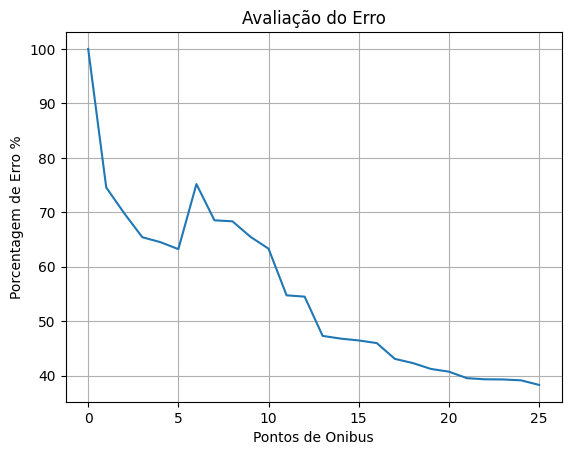

In [ ]:
plt.plot(Erros)
plt.title('Avaliação do Erro')
plt.xlabel('Pontos de Onibus')
plt.ylabel('Porcentagem de Erro %')
plt.grid()
plt.show()

In [ ]:
agrupamento_junho = matriz_junho.groupby(['PontoInicial','PontoFinal']).agg({'sequence':'count'}).reset_index()
agrupamento_junho.pivot(index= 'PontoInicial', columns='PontoFinal', values='sequence').fillna(0)

PontoFinal
PontoInicial


In [ ]:
matriz_junho

,index_col,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF,PontoFinal,dist_x,PontoInicial,dist_y
0,0_6,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2046.926540,3183.0,-22.826777,-47.061416,-22.829708,-47.060686,19,19.0,None,0.000691
1,1_6,1,2,Manha,2021-06-01 06:44:07,2021-06-01 12:33:53,6,390.572020,804.0,-22.826890,-47.061367,-22.827097,-47.061306,19,19.0,None,0.000065
2,2_6,1,7,Manha,2021-06-01 06:44:48,2021-06-01 12:34:20,7,1171.826118,787.0,-22.827616,-47.061038,-22.828888,-47.060592,14,14.0,None,0.001064
3,3_6,1,7,Tarde,2021-06-01 13:11:22,2021-06-01 16:43:41,6,1165.803784,193.0,-22.827083,-47.061219,-22.828920,-47.060559,14,14.0,None,0.001067
4,4_6,1,8,Tarde,2021-06-01 13:04:16,2021-06-01 19:10:52,7,483.412306,359.0,-22.813787,-47.060110,-22.831784,-47.062191,1,1.0,None,0.002320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16541,6010_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,18,18.0,None,0.000213
16542,6011_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,18,18.0,None,0.000213
16543,6012_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,18,18.0,None,0.000213
16544,6013_8,31,93166,Tarde,2021-08-31 16:19:17,2021-08-31 16:23:33,1,821.356800,256.0,-22.831021,-47.063912,-22.824985,-47.065243,14,14.0,None,0.000265


In [ ]:
agrupamento_junho = matriz_junho.groupby(['PontoInicial','PontoFinal']).agg({'sequence':'count'}).reset_index()
agrupamento_junho.pivot(index= 'PontoInicial', columns='PontoFinal', values='sequence').fillna(0)


pivotttt = matriz_junho_agrupada[   (matriz_junho_agrupada['dataInicio'] == 6)  &
                                    (matriz_junho_agrupada['day'] == 1)         &
                                    (matriz_junho_agrupada['periodo'] == 'Tarde')].pivot(index= 'PontoInicial', columns='PontoFinal', values='sequence').fillna(0)
pivotttt

In [ ]:
pivotttt = matriz_junho_agrupada[   (matriz_junho_agrupada['dataInicio'] == 6)  &
                                    (matriz_junho_agrupada['day'] == 1)         &
                                    (matriz_junho_agrupada['periodo'] == 'Tarde')].pivot(index= 'PontoInicial', columns='PontoFinal', values='sequence').fillna(0)
pivotttt

KeyError: 'day'